In [ ]:
pip install -U finance-datareader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.6 MB/s eta 0:00:00


In [ ]:
#data preprocessing
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler

#machine learning
import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

# Setting Seed for Score Assignments
import random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

### 2. Loading the Dataset

#### Loading Sentiment Analysis Results

In [ ]:
ds_data = pd.read_csv('daily_sentiment_scores.csv', index_col=0)
ds_data = ds_data.iloc[:, 1]
ds_data.head()
ds_data.index = pd.to_datetime(ds_data.index)

#### Loading Stock Price Data of Tesla

In [ ]:
start = (2020, 1, 1)
start_time = datetime.datetime(*start)
end = (2020, 12, 31)
end_time = datetime.datetime(*end)

# Loading Samsung Electronic Co,. Ltd. (KS: 005930) Data from Yahoo Finance
df = fdr.DataReader('TSLA', start_time, end_time)

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
2020-01-02,28.299999,28.713333,28.114000,28.684000,142981500,28.684000
2020-01-03,29.366667,30.266666,29.128000,29.534000,266677500,29.534000
2020-01-06,29.364668,30.104000,29.333332,30.102667,151995000,30.102667
2020-01-07,30.760000,31.441999,30.224001,31.270666,268231500,31.270666
2020-01-08,31.580000,33.232666,31.215334,32.809334,467164500,32.809334


In [ ]:
df.tail()

,Open,High,Low,Close,Volume,Adj Close
2020-12-23,210.733337,217.166672,207.523331,215.326660,99519000,215.326660
2020-12-24,214.330002,222.029999,213.666672,220.589996,68596800,220.589996
2020-12-28,224.836670,227.133331,220.266663,221.229996,96835800,221.229996
2020-12-29,220.333328,223.300003,218.333328,221.996674,68732400,221.996674
2020-12-30,224.000000,232.199997,222.786667,231.593338,128538000,231.593338


In [ ]:
df

,Open,High,Low,Close,Volume,Adj Close
2020-01-02,28.299999,28.713333,28.114000,28.684000,142981500,28.684000
2020-01-03,29.366667,30.266666,29.128000,29.534000,266677500,29.534000
2020-01-06,29.364668,30.104000,29.333332,30.102667,151995000,30.102667
2020-01-07,30.760000,31.441999,30.224001,31.270666,268231500,31.270666
2020-01-08,31.580000,33.232666,31.215334,32.809334,467164500,32.809334
...,...,...,...,...,...,...
2020-12-23,210.733337,217.166672,207.523331,215.326660,99519000,215.326660
2020-12-24,214.330002,222.029999,213.666672,220.589996,68596800,220.589996
2020-12-28,224.836670,227.133331,220.266663,221.229996,96835800,221.229996
2020-12-29,220.333328,223.300003,218.333328,221.996674,68732400,221.996674


In [ ]:
df = df.set_index(pd.to_datetime(df.index))
df = pd.merge(df, ds_data, left_index=True, right_index=True, how='inner')
df.head()


,Open,High,Low,Close,Volume,Adj Close,sentiment_final
2020-01-02,28.299999,28.713333,28.114000,28.684000,142981500,28.684000,0.161528
2020-01-03,29.366667,30.266666,29.128000,29.534000,266677500,29.534000,0.128297
2020-01-06,29.364668,30.104000,29.333332,30.102667,151995000,30.102667,0.117547
2020-01-07,30.760000,31.441999,30.224001,31.270666,268231500,31.270666,0.104325
2020-01-08,31.580000,33.232666,31.215334,32.809334,467164500,32.809334,0.123884


In [ ]:
X = df[['Close', 'Open', 'High', 'Low', 'Volume', 'sentiment_final']].iloc[:-1, :]
y = pd.DataFrame(df['Close']).shift(-1).dropna()

### 3. Scaling and Converting Data (With Sentiment Analysis Results)

We can see that there is a big difference between volume and other values. In this case, LSTM models need to recognize the difference between these two scales: volume and the rest values, which can be a burden to train data. Therefore, we reduce by scaling all variables from 0 to 1 to reduce the burden on the model.

In [ ]:
MMS = MinMaxScaler(feature_range = (0, 1))

X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y)

X_df = pd.DataFrame(X_data)
X_df.columns = X.columns
X_df.index = X.index
y_df = pd.DataFrame(y_data)
y_df.columns = y.columns
y_df.index = y.index
# Input Variables (5 variables)
threshold_date = "2020-10-01"

X_train = X_df[X_df.index < threshold_date]
X_test = X_df[X_df.index >= threshold_date]
y_train = y_df[y_df.index < threshold_date]
y_test = y_df[y_df.index >= threshold_date]

print("Training Set Shape", X_train.shape, y_train.shape)
print("Testing Set Shape", X_test.shape, y_test.shape)

Training Set Shape (189, 6) (189, 1)
Testing Set Shape (62, 6) (62, 1)


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train.values))
X_test_tensors = Variable(torch.Tensor(X_test.values))

y_train_tensors = Variable(torch.Tensor(y_train.values))
y_test_tensors = Variable(torch.Tensor(y_test.values))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([189, 1, 6]) torch.Size([189, 1])
Testing Shape torch.Size([62, 1, 6]) torch.Size([62, 1])


In [ ]:
device = torch.device('cpu')

### 4. Building LSTM Model

In [ ]:
class LSTM_model(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM_model, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #LSTM layer
    self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer

  def forward(self,x):
    h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state
    # Propagate input through LSTM

    out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

    # Decode the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

### 5. Setting Hyperparameters and Training Data

In [ ]:
num_epochs = 10000
learning_rate = 0.001

input_size = 6 # number of features (+ Add Sentiment Analysis Results)
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked LSTM layers

num_classes = 1 #number of output classes
LSTM_1 = LSTM_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(LSTM_1.parameters(), lr=learning_rate)  # adam optimizer

In [ ]:
for epoch in range(num_epochs+1):
    outputs = LSTM_1.forward(X_train_tensors_final.to(device)) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = loss_function(outputs, y_train_tensors.to(device))

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop

    if epoch % 100 == 0:
        print("Epoch: %d, Loss: %1.4f" % (epoch, loss.item()))

Epoch: 0, Loss: 0.1112
Epoch: 100, Loss: 0.0445
Epoch: 200, Loss: 0.0296
Epoch: 300, Loss: 0.0212
Epoch: 400, Loss: 0.0135
Epoch: 500, Loss: 0.0064
Epoch: 600, Loss: 0.0029
Epoch: 700, Loss: 0.0021
Epoch: 800, Loss: 0.0017
Epoch: 900, Loss: 0.0014
Epoch: 1000, Loss: 0.0012
Epoch: 1100, Loss: 0.0010
Epoch: 1200, Loss: 0.0009
Epoch: 1300, Loss: 0.0008
Epoch: 1400, Loss: 0.0008
Epoch: 1500, Loss: 0.0007
Epoch: 1600, Loss: 0.0007
Epoch: 1700, Loss: 0.0007
Epoch: 1800, Loss: 0.0007
Epoch: 1900, Loss: 0.0006
Epoch: 2000, Loss: 0.0006
Epoch: 2100, Loss: 0.0006
Epoch: 2200, Loss: 0.0006
Epoch: 2300, Loss: 0.0006
Epoch: 2400, Loss: 0.0006
Epoch: 2500, Loss: 0.0006
Epoch: 2600, Loss: 0.0006
Epoch: 2700, Loss: 0.0006
Epoch: 2800, Loss: 0.0006
Epoch: 2900, Loss: 0.0006
Epoch: 3000, Loss: 0.0006
Epoch: 3100, Loss: 0.0006
Epoch: 3200, Loss: 0.0006
Epoch: 3300, Loss: 0.0006
Epoch: 3400, Loss: 0.0006
Epoch: 3500, Loss: 0.0005
Epoch: 3600, Loss: 0.0005
Epoch: 3700, Loss: 0.0005
Epoch: 3800, Loss: 0.000

In [ ]:
plt.rcParams["figure.figsize"] = (32,18)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 20})

### 6. Results

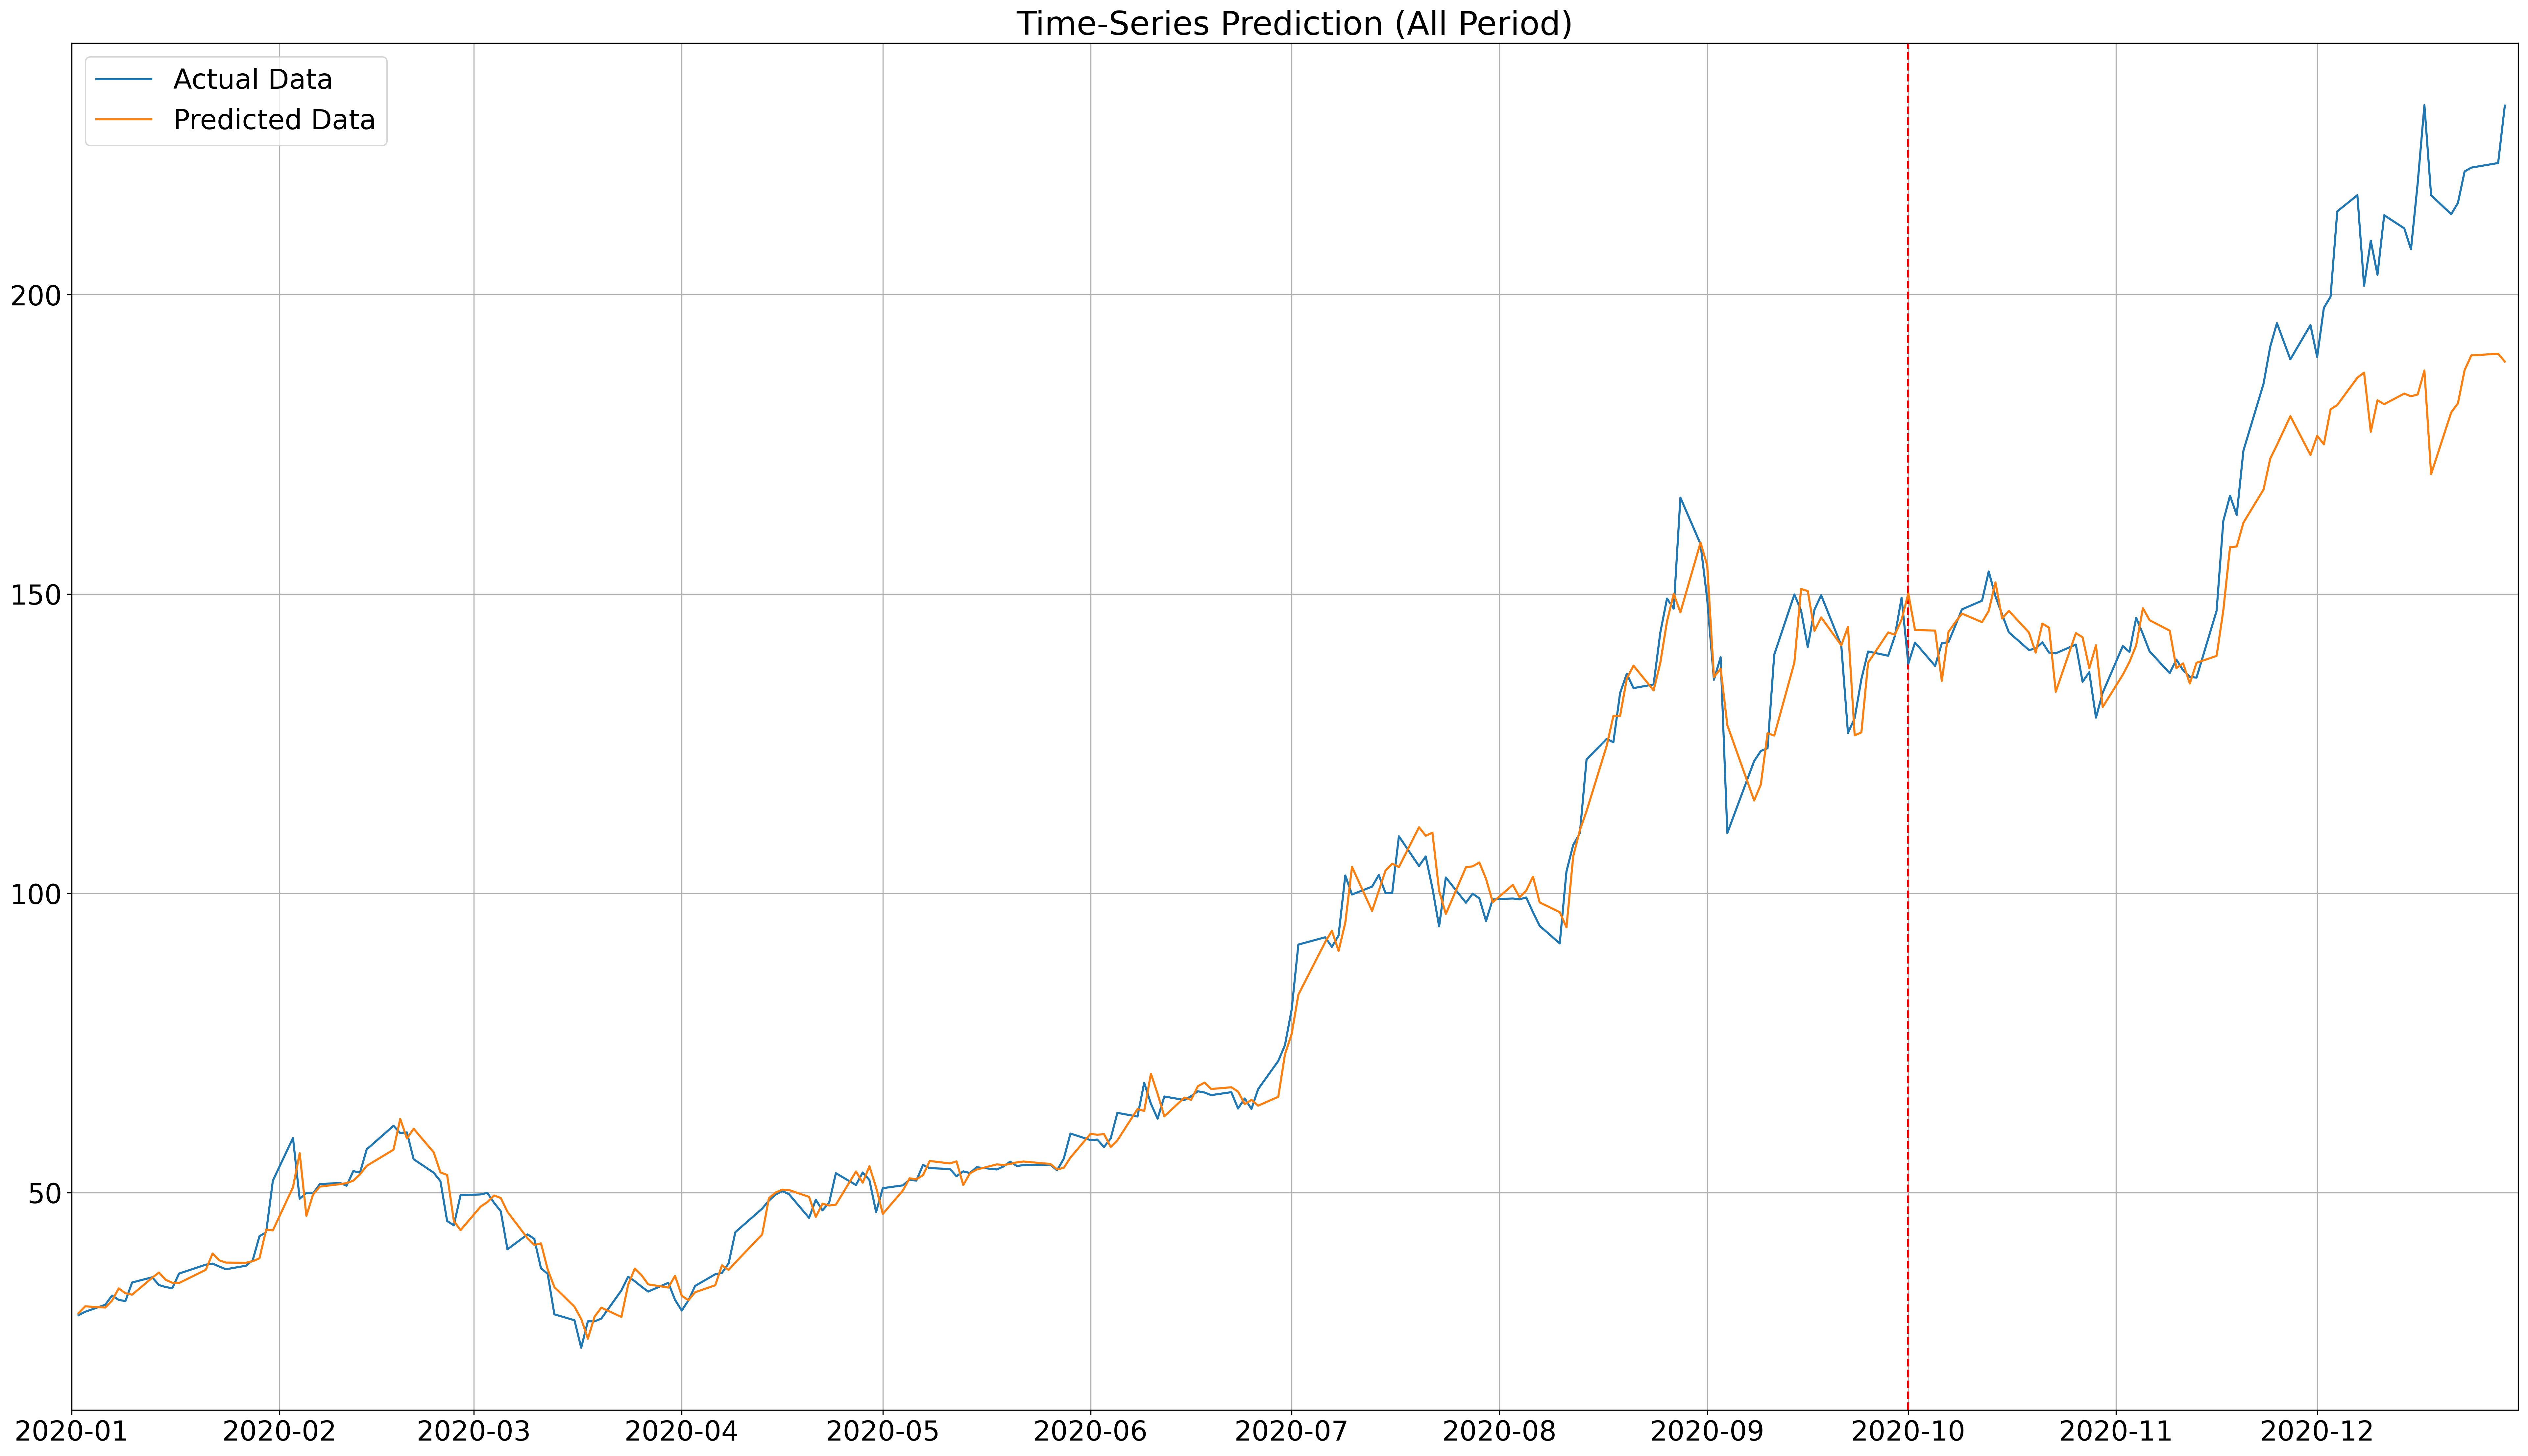

In [ ]:
df_X = Variable(torch.Tensor(X_data)) #converting to Tensors
df_y = Variable(torch.Tensor(y_data))
#reshaping the dataset
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
train_predict = LSTM_1(df_X.to(device)) #forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y.data.numpy()

data_predict = MMS.inverse_transform(data_predict) #reverse transformation
dataY_plot = MMS.inverse_transform(dataY_plot)

plt.xlim(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31))
test_line = datetime.datetime(2020, 10, 1)
plt.axvline(x=test_line, c='r', linestyle='--') #size of the training set

plt.plot(df.index.to_pydatetime()[:-1], dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime()[:-1], data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (All Period)')
plt.legend()
plt.show()

In [ ]:
MSE = mean_squared_error(dataY_plot, data_predict)
print('Mean Squared Error:', MSE)

Mean Squared Error: 103.97036743164062


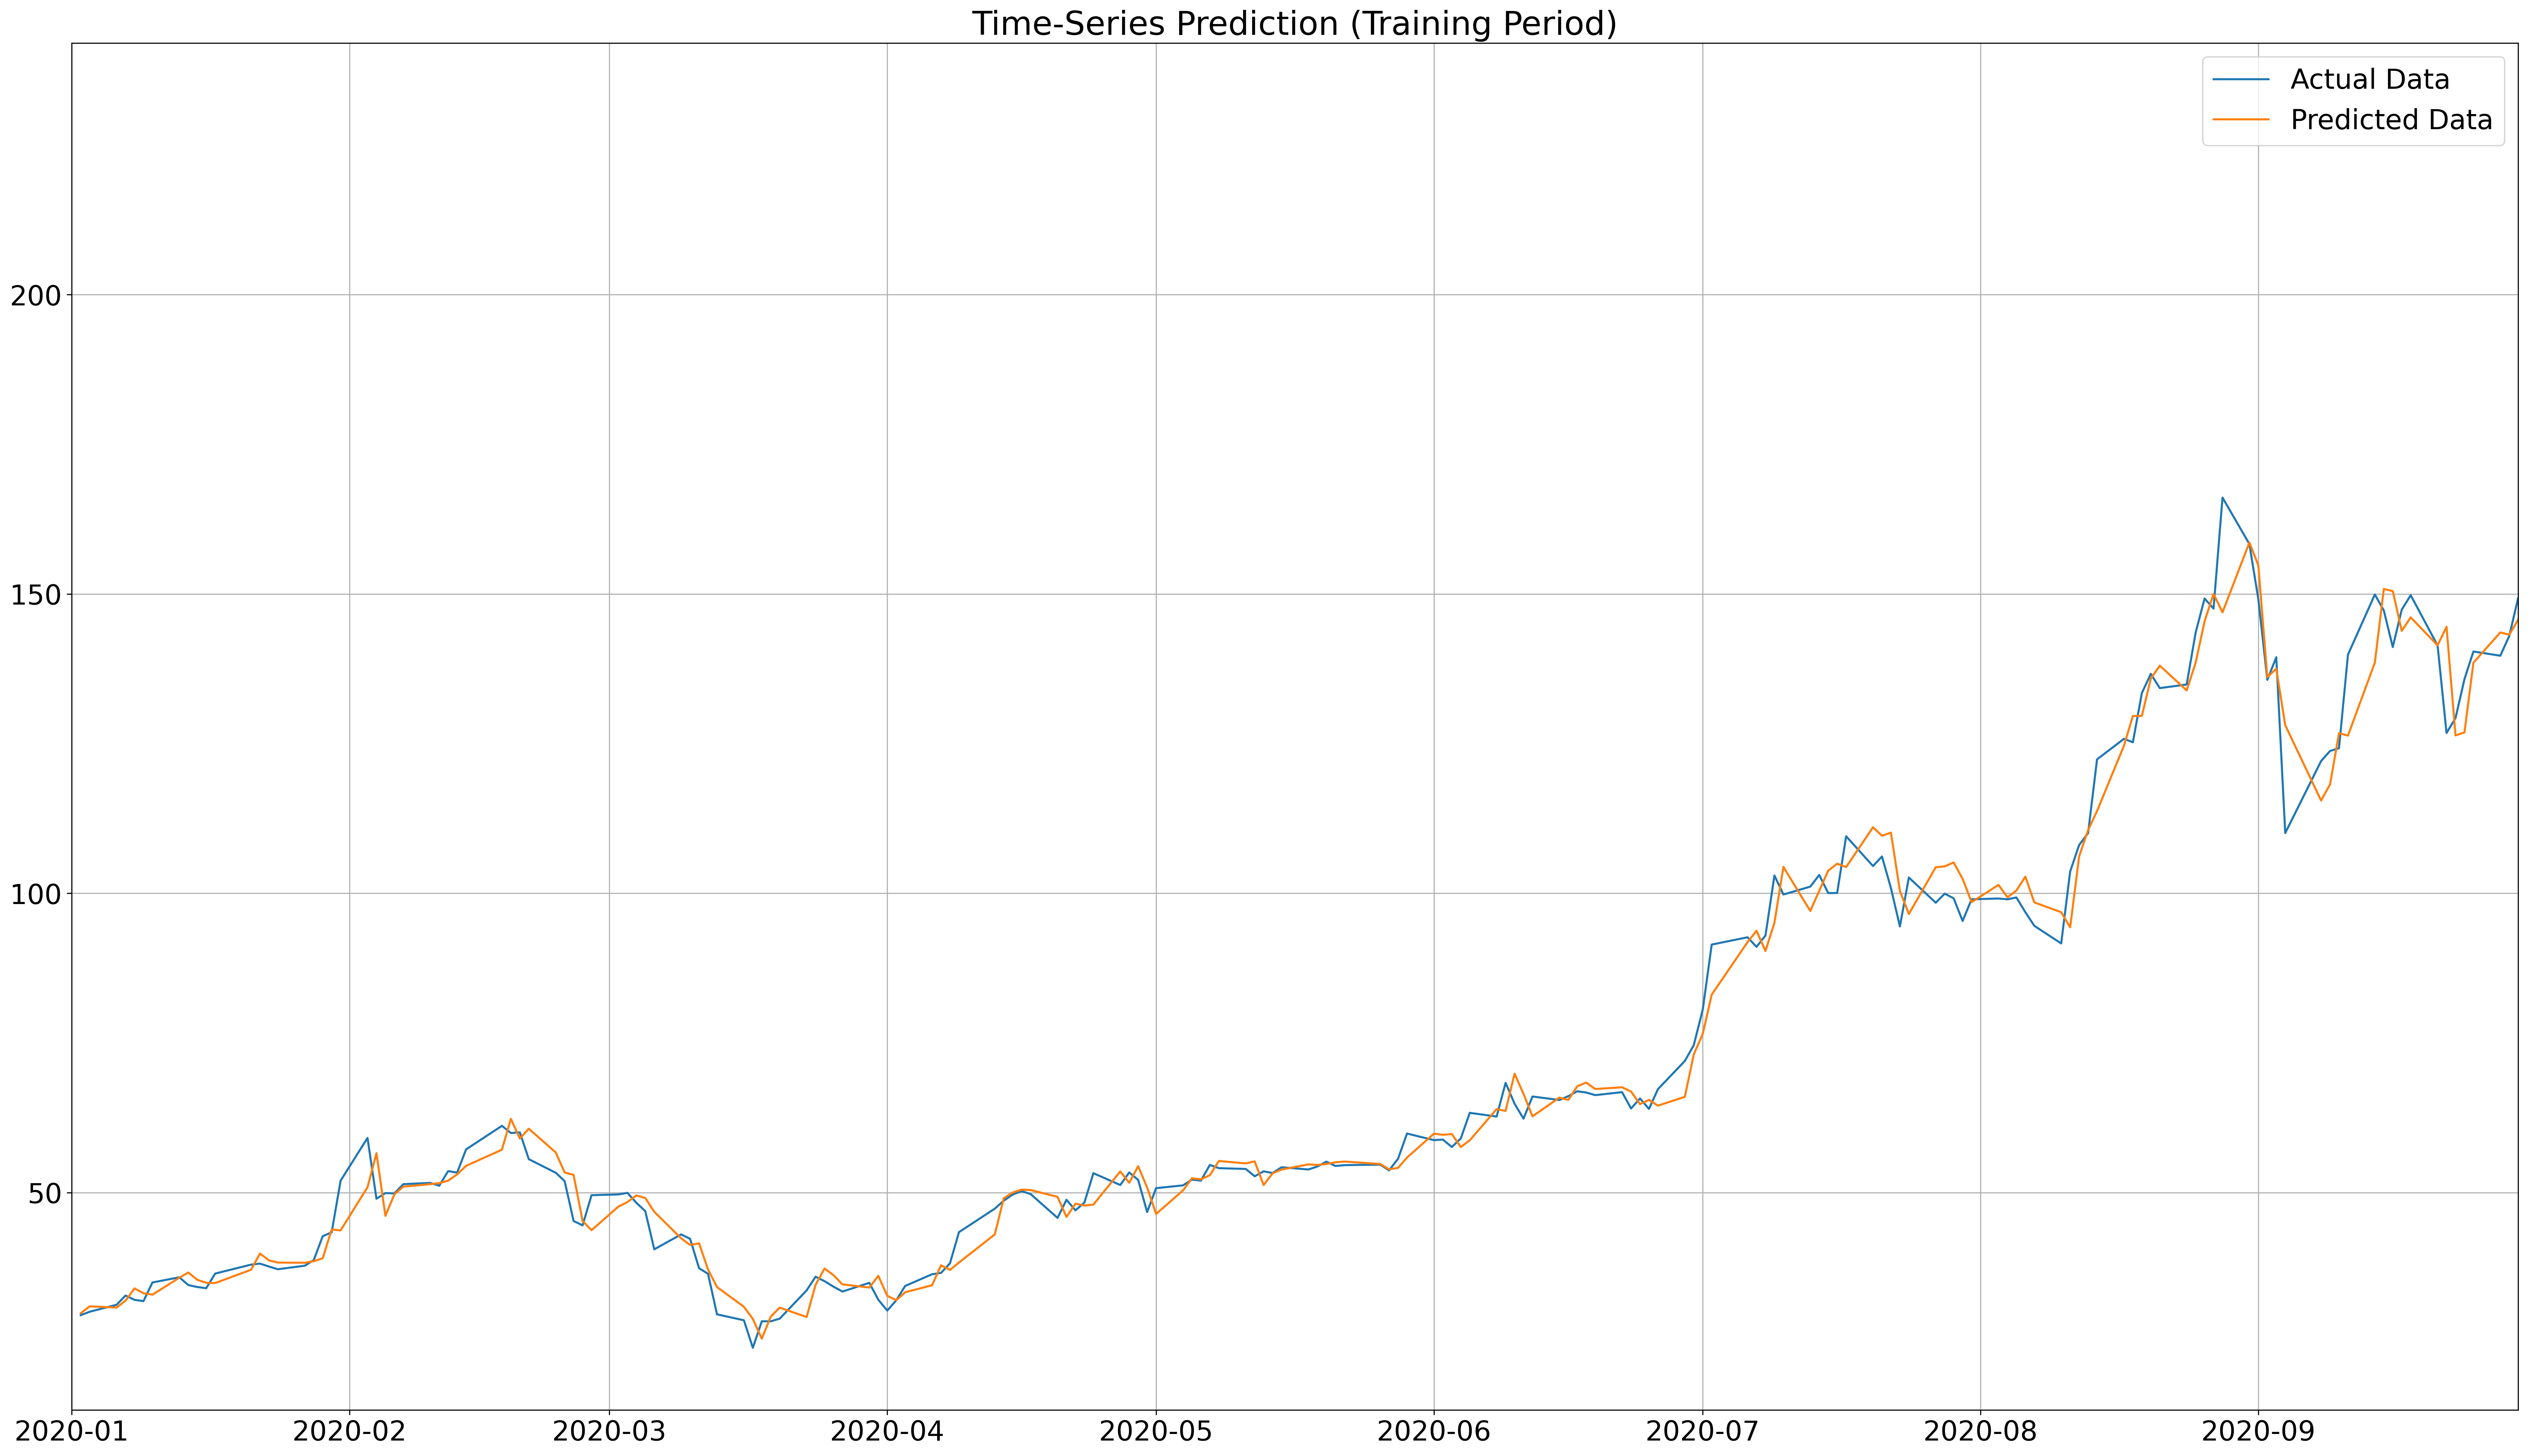

In [ ]:
plt.xlim(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 9, 30))
plt.plot(df.index.to_pydatetime()[:-1], dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime()[:-1], data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (Training Period)')
plt.legend()
plt.show()

In [ ]:
MSE_train = mean_squared_error(dataY_plot[:189], data_predict[:189])
print('Mean Squared Error (Training Data):', MSE_train)

Mean Squared Error (Training Data): 19.12900161743164


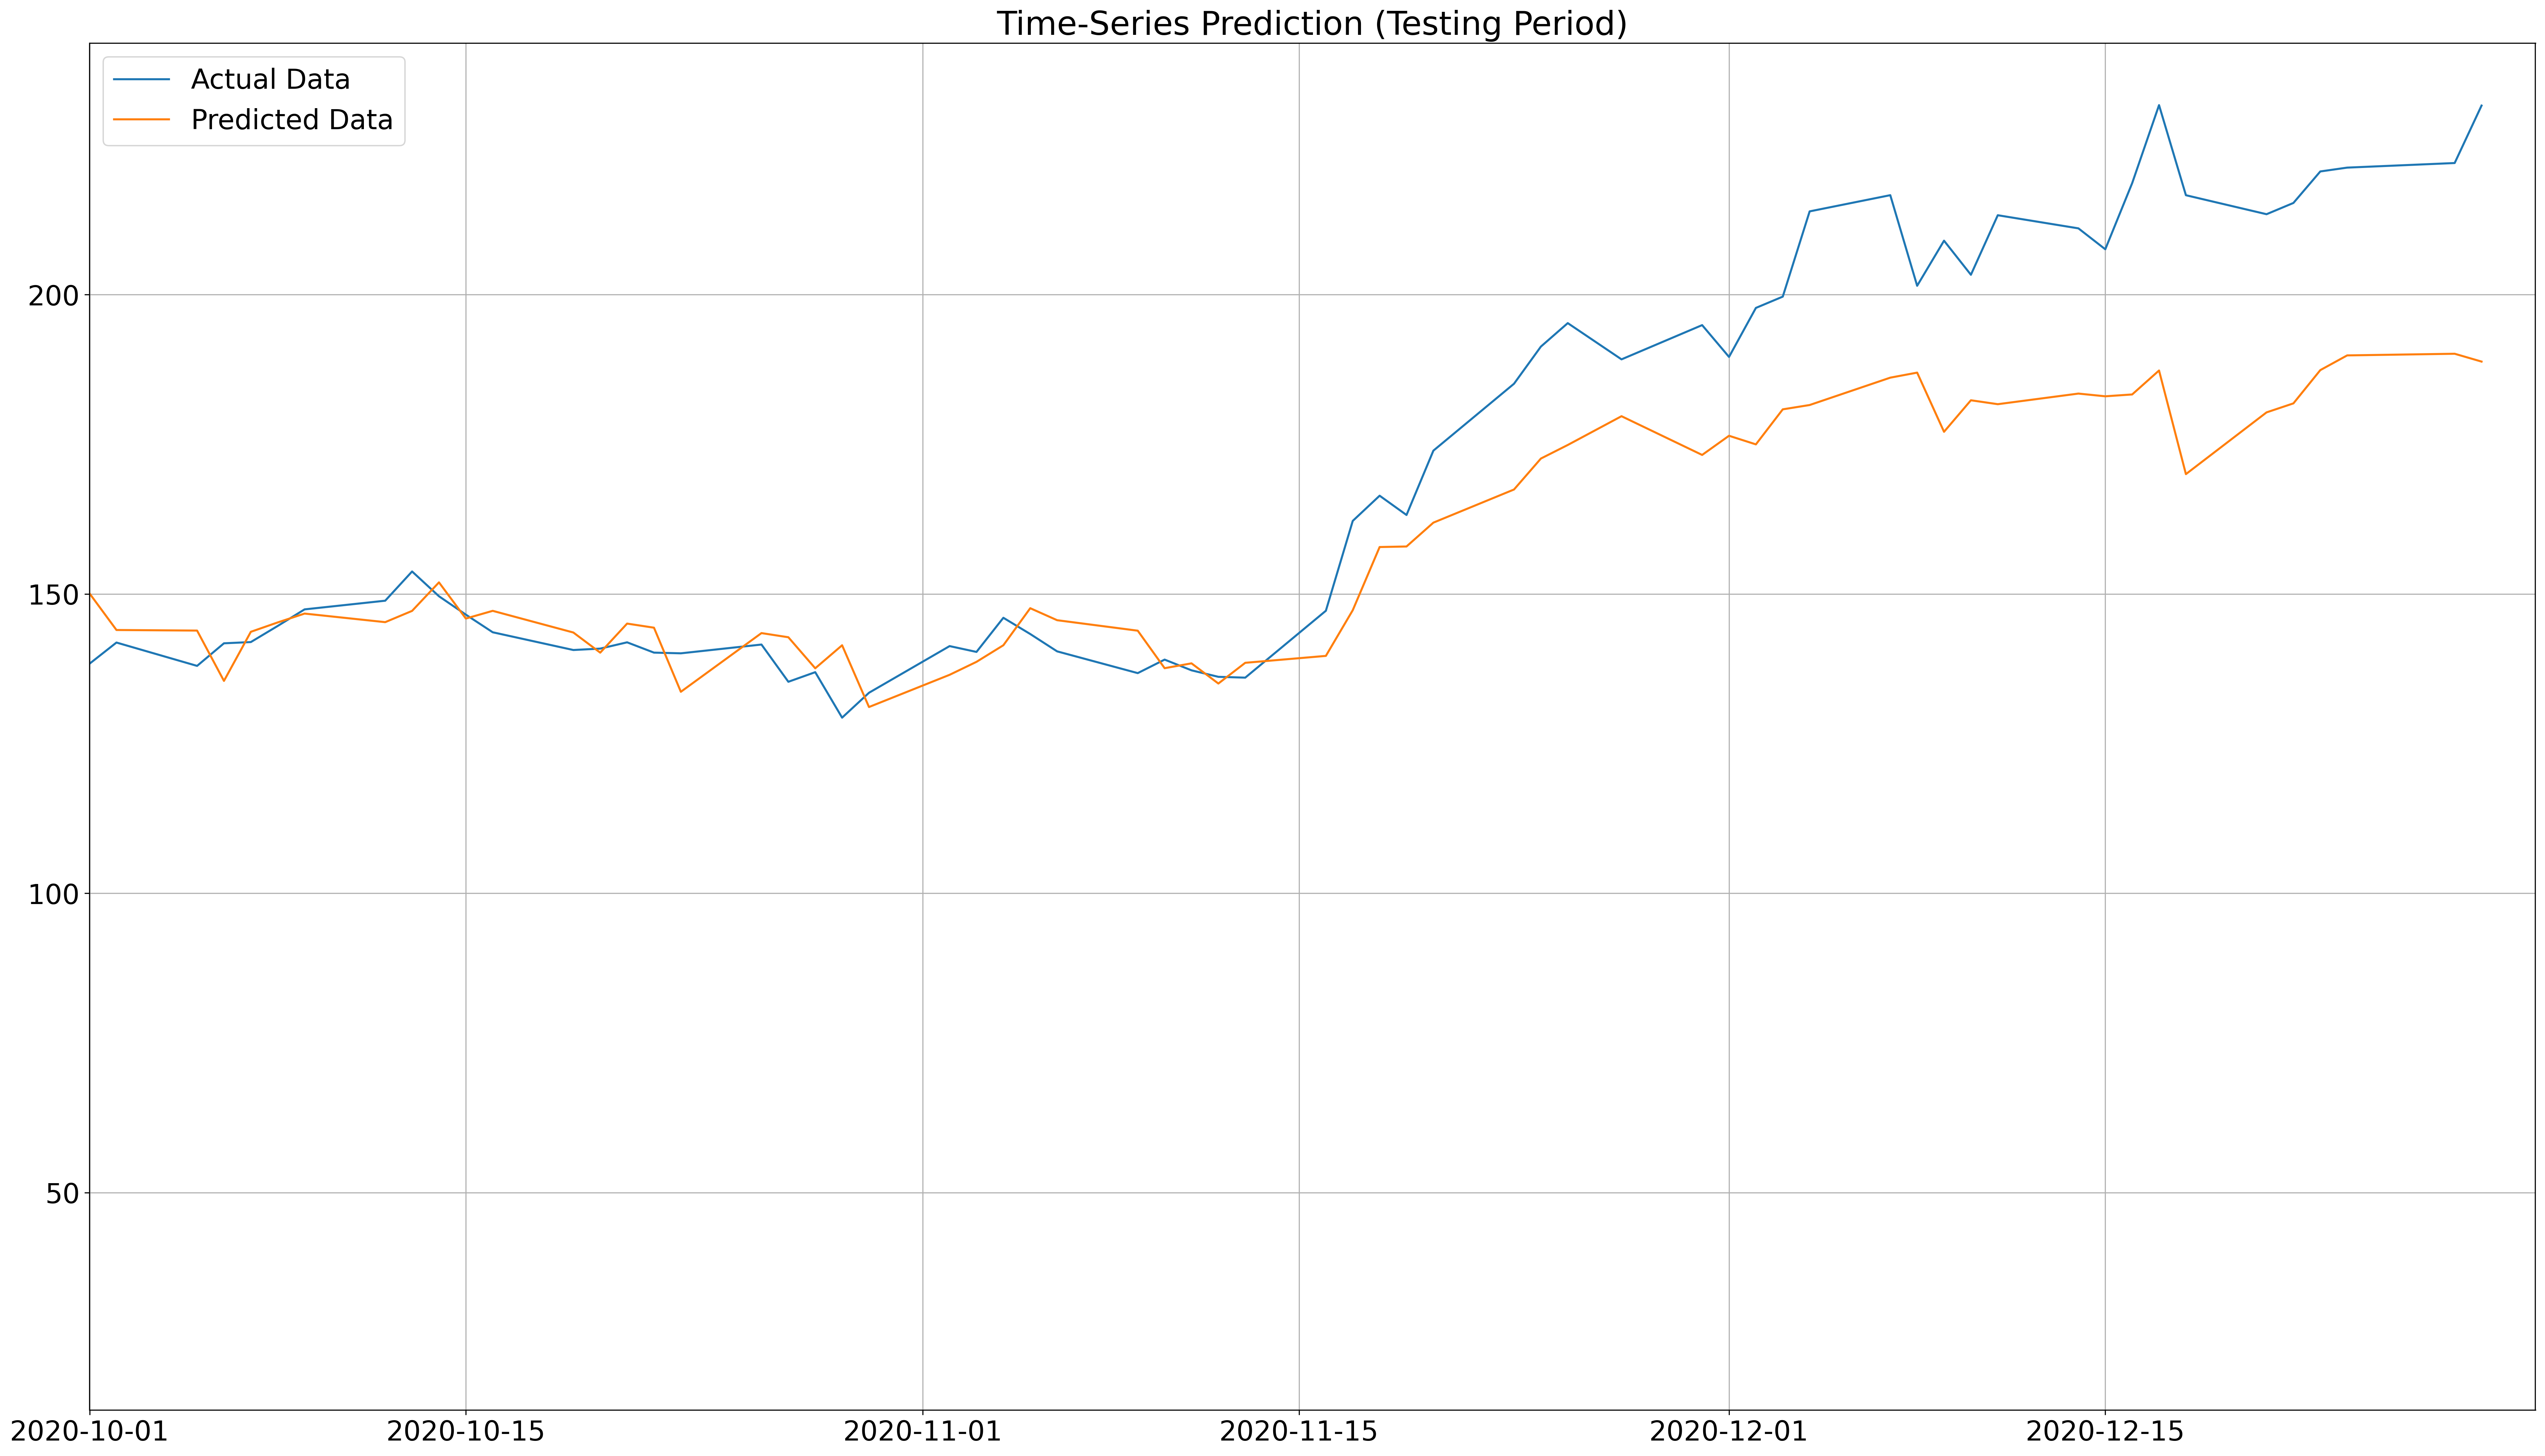

In [ ]:
plt.xlim(datetime.datetime(2020, 10, 1), datetime.datetime(2020, 12, 31))
plt.plot(df.index.to_pydatetime()[:-1], dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime()[:-1], data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (Testing Period)')
plt.legend()
plt.show()

In [ ]:
MSE_test = mean_squared_error(dataY_plot[189:], data_predict[189:])
print('Mean Squared Error (Test Data):', MSE_test)

Mean Squared Error (Test Data): 362.59967041015625
